<font face="Chalkboard" color="darkBlue" size=10>
Gradient Boosting Implementation With Choice of Regressors</font>

## What is gradient boosting?

> Gradient boosting is a machine learning technique used in regression and classification tasks, among others. It gives a prediction model in the form of an ensemble of weak prediction models.

### In other words, intuition behind gradient boosting can be explained as:
Assume you have an regressor $F$ and, for the observation $x_i$ we make the prediction $F(x_i)$. To improve the predictions, we can regard $F$ as a 'weak learner' and therefore train a decision tree (we can call it $h$) where the new output is $y_i-F(x_i)$. So, the new predictor is trained on the residuals of the previous one. Thus, there are increased chances that the new regressor

$$\large F + h$$ 

is better than the old one, $F.$



## Most commonly, Gradient Boosting Algorithms are implemented using tree-based regressors/classifiers. The most popular gradient boosting libraries and frameworks such as XGBoost, LightGBM, and Adaboost all use Tree-based learners.

> But based on the logic of gradient boosting, tree-based learners are not the only viablel choice.

> In this notebook we will explore the implementation gradient boosting using non-tree-based learners.

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 130

In [16]:
# imports
import numpy as np
import pandas as pd
from math import ceil
from scipy import linalg
from scipy.interpolate import interp1d
from scipy.linalg import lstsq
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from scipy.spatial import Delaunay
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
import scipy.stats as stats
from sklearn.model_selection import train_test_split as tts, KFold
from sklearn.metrics import mean_squared_error as mse
from scipy.interpolate import interp1d, griddata, LinearNDInterpolator, NearestNDInterpolator
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler, PolynomialFeatures
import statsmodels as sm
#import statsmodels.api as sm
from math import ceil
from IPython.display import Image
from IPython.display import display
plt.style.use('seaborn-white')

# the following line(s) are necessary if you want to make SKlearn compliant functions
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

# Adapted multi-dimentional Lowess Regressor as base learner

Based on the following papers:




>William S. Cleveland: "Robust locally weighted regression and smoothing
scatterplots", Journal of the American Statistical Association, December 1979,
volume 74, number 368, pp. 829-836.


>William S. Cleveland and Susan J. Devlin: "Locally weighted regression: An
approach to regression analysis by local fitting", Journal of the American
Statistical Association, September 1988, volume 83, number 403, pp. 596-610.
"""
##inspired by Alexandre Gramfort's univariate implementation 

original version of Gramfort's implementation of LOWESS: https://gist.github.com/agramfort/850437


# Built in different choices of kernels to apply to Lowess

### Kernels in LOWESS

> Kernels are the "Bump" or "mound shaped" functions in the animation. They are used to produce the "weights" used for each observation $x$. Different values of weights are visually highlighted as organge in the animation above as the kernel iterates through the data. 

Below are the parent functions of the kernels to produce the weights

1.   The Exponential Kernel

$$ K(x):= e^{-\frac{\|x\|^2}{2}}$$


2.   The Tricubic Kernel

$$ K(x):=\begin{cases}
(1-\|x\|^3)^3 \;\;\;if \;\;\; \|x\|<1 \\
0 \;\;\; \text{otherwise}
\end{cases}
$$

3.   The Epanechnikov Kernel

$$ K(x):=\begin{cases}
\frac{3}{4}(1-\|x\|^2) \;\;\;if \;\;\; \|x\|<1 \\
0 \;\;\; \text{otherwise}
\end{cases}
$$

3.   The Quartic Kernel

$$ K(x):=\begin{cases}
\frac{15}{16}(1-\|x\|^2)^2 \;\;\;if \;\;\; \|x\|<1 \\
0 \;\;\; \text{otherwise}
\end{cases}
$$

In [17]:

def lowess_regressor(X, y,x_new, kernel_type = 'tricubic',f=1. / 3., iter=1,intercept =True, pca_components = 3):
    #kernels and weight calculation functions
    # we need to compute all pairwise distances and figure out the k-nearest neightbors
    scale = StandardScaler()
    def tricubic_neighbors(x, xi, n):

        distances = np.sqrt(np.sum((x - xi)**2, axis=1))
        indices = np.argsort(distances)
        max = distances[indices[n]]
        w = np.where(distances>max,0,70/81*(1-distances**3)**3)
        return w   
    def gaussian_neighbors(x, xi, n):

        distances = np.sqrt(np.sum((x - xi)**2, axis=1))
        indices = np.argsort(distances)
        max = distances[indices[n]]
        w = np.where(distances>max,0,1/(np.sqrt(2*np.pi))*np.exp(-1/2*distances**2))
        return w
    def epanechnikov_neighbors(x, xi, n):

        distances = np.sqrt(np.sum((x - xi)**2, axis=1))
        indices = np.argsort(distances)
        max = distances[indices[n]]
        w = np.where(distances>max,0,3/4*(1-distances**2))
        return w
    def quartic_neighbors(x, xi, n):

        distances = np.sqrt(np.sum((x - xi)**2, axis=1))
        indices = np.argsort(distances)
        max = distances[indices[n]]
        w = np.where(distances>max,0,15/16*(1-distances**2)**2)
        return w

    def weights_matrix_neighbors(x,x_new,kernel,n):
        if x_new.shape == 1:
            x_new=x_new.reshape(1,-1)
        length = len(x_new)
        return np.array([kernel(x,x_new[i],n) for i in range(length)])
    
    if kernel_type in ['tricubic','gaussian','epanechnikov','quartic']:
        if kernel_type == 'tricubic':
            kernel = tricubic_neighbors
        if kernel_type == 'gaussian':
            kernel = gaussian_neighbors  
        if kernel_type == 'epanechnikov':
            kernel = epanechnikov_neighbors    
        if kernel_type == 'quartic':
            kernel = quartic_neighbors
    else:
        raise ValueError("kernel type must be 'tricubic','gaussian','epanechnikov' or 'quartic' ")
    X, x_new, y =np.array(X), np.array(x_new), np.array(y)


    length = len(X) # get the length of x
    r = int(ceil(f * length)) # decies how many point around the Xi is important

    if len(y.shape)==1: # here we make column vectors
        y = y.reshape(-1,1)

    if len(X.shape)==1:
        X = X.reshape(-1,1)
        
    if intercept:
        X1 = np.column_stack([np.ones((len(X),1)),X])
    else:
        X1 = X

        # calculates the weights 
    w = weights_matrix_neighbors(X,X,kernel,r)
#this variant is predicting on the train
#the predict function uses linear interpolatioin to predict

    yest = np.zeros(length)
    delta = np.ones(length) # this creates adaptiveness

    for iteration in range(iter): # iter to apply rounds of readjusting of weights
        for i in range(length): # forces intercept no matter what
            #W = np.diag(delta)* np.diag(w[i,:]) 
            W = np.diag(delta).dot(np.diag(w[i,:]))
            # when we multiply two diagonal metrices we get also a diagonal matrix
            b = np.transpose(X1).dot(W).dot(y)
            A = np.transpose(X1).dot(W).dot(X1)
            A = A + 0.001*np.eye(X1.shape[1]) # if we want L2 regularization
            #theta = linalg.solve(A, b) # A*theta = b
            beta, res, rnk, s = lstsq(A, b)
            yest[i] = np.dot(X1[i],beta)
         
        residuals = y.ravel() - yest # keeps the residuals
        # y is a column vector but yest is just a array, need to force them both to be either row or column vector
        s = np.median(np.abs(residuals)) # take median of residuals
        #
        delta = np.clip(residuals / (6.0 * s), -1, 1) 
        #
            # "standardize" the residuals, also cliping(discarding) residual outliers it is is greater than 6 * median
            # residuals that are bigger will get bigger weights, 
            # then those points will be given more importance(more influential)
            # re-adjustes the original weight
            # how robustification is applied

           
        delta = (1 - delta ** 2) ** 2
        
    
    # here we are making predictions for x_new by using an interpolation and the predictions we made for train data
    #
    
    if X.shape[1]==1:
        f = interp1d(x.flatten(),yest,fill_value='extrapolate')
        output = f(x_new)
    else:
        output = np.zeros(len(x_new))
        for i in range(len(x_new)):
            ind = np.argsort(np.sqrt(np.sum((X-x_new[i])**2,axis=1)))[:r]
            # the trick below is to have the Delaunay triangulation work --> getting first 3 PCA principle components
            #(often without this delaunay would be infinite loop), bypass deficiency in delaunay function
            pca = PCA(n_components=pca_components)
            X_pca = pca.fit_transform(X[ind])
            tri = Delaunay(X_pca,qhull_options='QJ')
            f = LinearNDInterpolator(tri,yest[ind]) 
            output[i] = f(pca.transform(np.array(x_new[i]).reshape(1,-1))) # the output may have NaN's where the data points from xnew are outside the convex hull of X 
    if sum(np.isnan(output))>0:
        g = NearestNDInterpolator(X,yest.ravel()) 
        # output[np.isnan(output)] = g(X[np.isnan(output)])
        output[np.isnan(output)] = g(x_new[np.isnan(output)])

    return output

#Create a class that could be used in sk-learn's sytax

In [18]:
class Lowess_AG_adapted:
    def __init__(self, f = 1/10, kernel_type = 'tricubic',iter = 1,intercept=True,pca_components =3):
        self.f = f
        self.iter = iter
        self.intercept = intercept
        self.kernel_type = kernel_type
        self.pca_components = pca_components
    
    def fit(self, x, y):
        f = self.f
        iter = self.iter
        kernel_type = self.kernel_type
        self.xtrain_ = x
        self.yhat_ = y

    def predict(self, x_new):
        check_is_fitted(self)
        x = self.xtrain_
        y = self.yhat_
        f = self.f
        iter = self.iter
        intercept = self.intercept
        kernel_type = self.kernel_type
        pca_components = self.pca_components
        return lowess_regressor(x, y, x_new, kernel_type,f, iter, intercept,pca_components) # this is actually our defined function of LOWESS

    def get_params(self, deep=True):
    # suppose this estimator has parameters "f", "iter" and "intercept"
        return {"f": self.f, "iter": self.iter,"intercept":self.intercept, "kernel_type":self.kernel_type}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# Simple Gradient Boosting implementation:

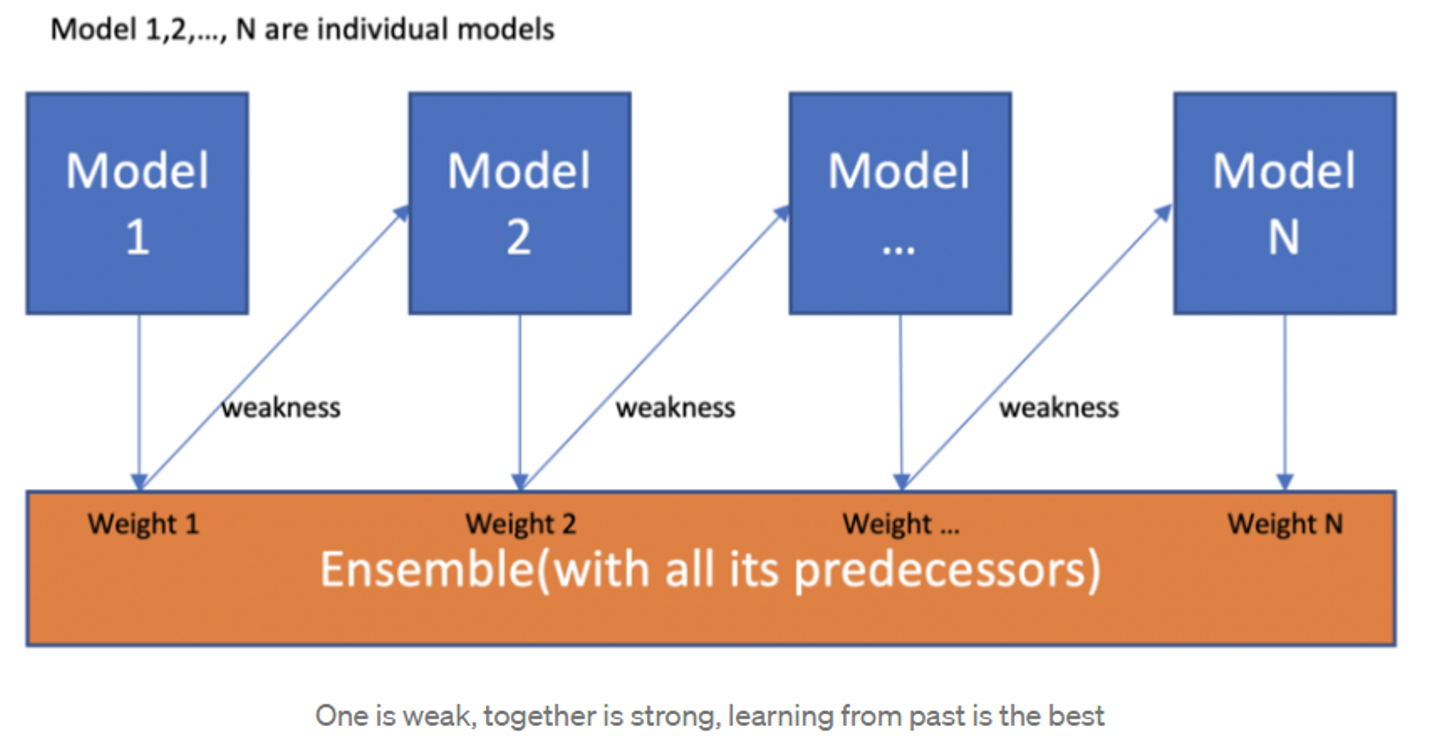![image.png]()

## The logic is very simple. We build additional regressor to predict the residuals(or "weakness") of the previous model, in effect making the previous regressor "stronger" by "making up" for its mistakes.

> We can repeat this process further, to further "strengthen" the previous regressor. When making predictions, the emsemble of all of the regressors will be "stronger" than any single one.

> **Here we implement a smaller, 2 regressor emsemble**

In [19]:
def boosted_regressor(X, y,x_new, model_1 = Lowess_AG_adapted( kernel_type = 'tricubic',f=1. / 5., iter=3,intercept =True, pca_components = 3), model_2 = RandomForestRegressor()):
  # we need decision trees
  # for training the boosted method we use x and y
  model1 = model_1
  model1.fit(X,y)
  residuals1 = y - model1.predict(X)
  #model2 = Lowess_AG_MD(f=f,iter=iter,intercept=intercept)
  model2 = model_2
  model2.fit(X,residuals1)
  output = model1.predict(x_new) + model2.predict(x_new)
  return output 

# Test of 3 smaller scale datasets:

1. Automobile dataset from UCI
>https://archive.ics.uci.edu/ml/datasets/automobile
2. Concreate Dataset from UCI
>https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength
3. Housing dataset from UCI
>https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

In [6]:
data_cars = pd.read_csv('drive/MyDrive/Colab Notebooks/data441/cars.csv')
data_concrete = pd.read_csv('drive/MyDrive/Colab Notebooks/data441/concrete.csv')
data_housing = pd.read_csv('drive/MyDrive/Colab Notebooks/data441/housing.csv')

In [23]:
x_cars = data_cars.loc[:,'CYL':"WGT"]
y_cars = data_cars.loc[:,'MPG']

In [7]:
x_concrete = data_concrete.loc[:,'cement':'age'].values
y_concrete = data_concrete['strength'].values

In [38]:
x_housing = data_housing.loc[:,['tract','crime','residential','industrial','nox','rooms','older','distance','highway','tax','ptratio','lstat']].values
y_housing = data_housing.loc[:,'cmedv']

In [8]:
def k_fold(X,y,model1,model2):
    mse_lwr = []
    #mse_rf = []
    kf = KFold(n_splits=2,shuffle=True,random_state=1234)
    scale =StandardScaler()
    #model_boosted = boosted_regressor(model_1 = model1, model_2 = model2)

    for idxtrain, idxtest in kf.split(X):
        xtrain = X[idxtrain]
        ytrain = y[idxtrain]
        ytest = y[idxtest]
        xtest = X[idxtest]
        xtrain = scale.fit_transform(xtrain)
        xtest = scale.transform(xtest)

        yhat_lw = boosted_regressor(xtrain,ytrain,xtest,model_1 = model1, model_2 = model2)
        
       # model_rf.fit(xtrain,ytrain)
       # yhat_rf = model_rf.predict(xtest)

        mse_lwr.append(mse(ytest,yhat_lw))
        #mse_rf.append(mse(ytest,yhat_rf))
    print('The Cross-validated Mean Squared Error for the boosted regressor is : '+str(np.mean(mse_lwr)))
    #print('The Cross-validated Mean Squared Error for Random Forest is : '+str(np.mean(mse_rf)))

In [9]:
model_1 = Lowess_AG_adapted(f = 1./6.,iter=1)
model_2 = RandomForestRegressor(n_estimators=100,max_depth=7)

k_fold(x_concrete,y_concrete, model_1,model_2)

The Cross-validated Mean Squared Error for the boosted regressor is : 108.07947110915936


# What if we try a different kernel in the Lowess regressor?

In [12]:
model_1 = Lowess_AG_adapted(f = 1./6.,iter=1,kernel_type = 'gaussian')
model_2 = RandomForestRegressor(n_estimators=100,max_depth=7)

k_fold(x_concrete,y_concrete, model_1,model_2)

The Cross-validated Mean Squared Error for the boosted regressor is : 87.53965508207995


In [13]:
model_1 = Lowess_AG_adapted(f = 1./6.,iter=1,kernel_type = 'epanechnikov')
model_2 = RandomForestRegressor(n_estimators=100,max_depth=7)

k_fold(x_concrete,y_concrete, model_1,model_2)

The Cross-validated Mean Squared Error for the boosted regressor is : 1288.4131358041077


In [14]:
model_1 = Lowess_AG_adapted(f = 1./6.,iter=1,kernel_type = 'quartic')
model_2 = RandomForestRegressor(n_estimators=100,max_depth=7)

k_fold(x_concrete,y_concrete, model_1,model_2)

The Cross-validated Mean Squared Error for the boosted regressor is : 85.03283327031053


# The cars data set

In [29]:
import xgboost as xgb

In [27]:
model_1 = Lowess_AG_adapted(f = 1./6.,iter=1,kernel_type = 'gaussian')
model_2 = RandomForestRegressor(n_estimators=100,max_depth=5)

k_fold(x_cars.values,y_cars, model_1,model_2)

The Cross-validated Mean Squared Error for the boosted regressor is : 17.870428959017964


In [35]:

model_1 = Lowess_AG_adapted(f = 1./6.,iter=1,kernel_type = 'gaussian')
model_2 = xgb.XGBRegressor(n_estimators=100, max_depth=5)

k_fold(x_cars.values,y_cars, model_1,model_2)

The Cross-validated Mean Squared Error for the boosted regressor is : 26.37444563562134


In [36]:
model_1 = Lowess_AG_adapted(f = 1./6.,iter=1,kernel_type = 'quartic')
model_2 = xgb.XGBRegressor(n_estimators=100, max_depth=5)

k_fold(x_cars.values,y_cars, model_1,model_2)

The Cross-validated Mean Squared Error for the boosted regressor is : 26.019583885844845


# The housing dataset

In [39]:
model_1 = Lowess_AG_adapted(f = 1./6.,iter=1,kernel_type = 'gaussian')
model_2 = RandomForestRegressor(n_estimators=100,max_depth=5)

k_fold(x_housing,y_housing, model_1,model_2)

The Cross-validated Mean Squared Error for the boosted regressor is : 17.576427297337247


In [41]:

model_1 = Lowess_AG_adapted(f = 1./6.,iter=1,kernel_type = 'gaussian')
model_2 = xgb.XGBRegressor(n_estimators=100, max_depth=7)

k_fold(x_housing,y_housing, model_1,model_2)

The Cross-validated Mean Squared Error for the boosted regressor is : 17.150803749400286


In [42]:

model_1 = Lowess_AG_adapted(f = 1./6.,iter=1,kernel_type = 'quartic')
model_2 = xgb.XGBRegressor(n_estimators=100, max_depth=7)

k_fold(x_housing,y_housing, model_1,model_2)

The Cross-validated Mean Squared Error for the boosted regressor is : 25.381932985760848
